# Contributions to Sea Level Extremes

```{glue:figure} location_components
:scale: 35%
:align: right
```

In this notebook, we'll plot up and examine the various contributions to extreme sea levels through the lens of the nonstationary GEV analysis. Inspiration for these plots and analysis follows from {cite:t}`marra_advancing_2023` and {cite:t}`sweet_implications_2024`, which use the nonstationary GEV analysis of {cite:t}`mendez_analyzing_2007` to analyze the influence of climatic patterns like ENSO and PDO (for example) on extreme sea levels. All the calculations for these plots should be done in the nonstationary GEV notebooks: [nonstationaryGEV](notebooks/Annual/1_4_2_1_SL_Extremes_nonstationaryGEV.ipynb), and [nonstationaryGEV with Climate Index](notebooks/Annual/1_4_2_2_SL_Extremes_nonstationaryGEV_ClimateIndex.ipynb). 

## Setup

First we'll import the necessary functions, set up our directories, and get everything ready for plotting. This should be the same as we did previously in the [nonstationary extremes](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook.

In [71]:
%run ../0_1_setup.ipynb
import sys
import json
from scipy.stats import chi2
sys.path.append("../../python/nonstationaryGEV")
import helpers, models, plotting, imports

base_dir = Path(data_dir).parent
dirs = imports.make_directoryDict(base_dir)
model_output_dir = dirs['model_output_dir']
from helpers import adjust_w_for_plotting

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="invalid value encountered in create_collection")


Using custom paths from config_env.py
Data directory: /Users/jfiedler/Projects/SL_Indicators/data
Output directory: /Users/jfiedler/Projects/SL_Indicators/output


## Compile data 
```{caution}

Before running this, you will need to run the [non-stationary models](notebooks/nonstationaryGEV/monthly_extremes_non-stationaryGEV.ipynb) notebook first! Grab some coffee and get ready for some fun.
```

In the following codes we are just compiling the output and results from those models that have been saved to "model_output_dir" directory, following the methodology from {cite:t}`sweet_implications_2024`.

#### Choose station and climate indices
Here we'll use all tested indices

In [72]:
# get list of all directories in dirs['model_output_dir']
dirs_list = os.listdir(dirs['model_output_dir'])

# only keep the directories that are numbers
stationIDs = [int(d) for d in dirs_list if d.isdigit()]


# get station names from the best_params.json files
station_names = {}
for stationID in stationIDs:
    jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        station_names[stationID] = output['modelInfo']['station_name']

# sort the station names by the stationID
station_names = {k: v for k, v in sorted(station_names.items(), key=lambda item: item[0])}

station_names

{1611400: 'Nawiliwili',
 1612340: 'Honolulu',
 1612480: 'Mokuoloe',
 1615680: 'Kahului, Kahului Harbor',
 1617433: 'Kawaihae',
 1617760: 'Hilo, Hilo Bay, Kuhio Bay',
 1619910: 'Sand Island, Midway Islands'}

## Plot Components in time
First we'll make a function for plotting.

In [73]:
def plot_location(w, modelInfo, label, offset=0, component=True):
    # Unpack the w array
    b0, b1, b2, b3, b4, b5, b6 = w[0], w[3], w[4], w[5], w[6], w[7], w[8]
    a0, bLT, bCI, aCI, bN1, bN2 = w[1], w[9], w[10], w[11], w[12], w[13]

    # Check if w[10] (bCI) is zero (i.e., no covariate contribution)
    if bCI == 0:
        ti = np.arange(0, modelInfo['t'][-1], 0.01)
        CI = 0  # Covariate is zero if bCI is zero
    else:
        ti = pd.Series(modelInfo['t']) 
        CI = pd.Series(modelInfo['covariate'])  # Covariate values

        

    # Make sure CI and ti are aligned (if CI is a series)
    if isinstance(CI, pd.Series) and len(CI) != len(ti):
        raise ValueError("Length of covariate CI does not match the length of ti.")

    # Define mut (location(t)) as a function of ti and CI
    mut = (b0 * np.exp(bLT * ti) +
           b1 * np.cos(2 * np.pi * ti) + b2 * np.sin(2 * np.pi * ti) +
           b3 * np.cos(4 * np.pi * ti) + b4 * np.sin(4 * np.pi * ti) +
           b5 * np.cos(8 * np.pi * ti) + b6 * np.sin(8 * np.pi * ti) +
           bN1 * np.cos((2 * np.pi / 18.61) * ti) + bN2 * np.sin((2 * np.pi / 18.61) * ti) +
           (bCI * CI))  

    # Calculate the amplitudes for each harmonic and the covariate
    amp_annual = np.sqrt(b1**2 + b2**2)      # First harmonic (annual cycle)
    amp_semiannual = np.sqrt(b3**2 + b4**2)  # Second harmonic (semiannual cycle)
    amp_third = np.sqrt(b5**2 + b6**2)       # Third harmonic (quarterly or 8π cycle)
    amp_nodal = np.sqrt(bN1**2 + bN2**2)     # Nodal component
    amp_covariate = abs(bCI)                 # Covariate amplitude
    amp_trend = 0.5*(b0 * np.exp(bLT * modelInfo['t'][-1]) - b0*np.exp(bLT * modelInfo['t'][0]))  # Trend amplitude



    amp_seasonal = np.sqrt(amp_annual**2 + amp_semiannual**2 + amp_third**2)
    
    # Calculate the total amplitude
    amp = np.sqrt(amp_seasonal**2 + amp_nodal**2 + amp_covariate**2 + amp_trend**2)
    


    # Subtract the datum offset
    mut = mut - modelInfo['STNDtoMHHW']

    if component:
        mut_demeaned = mut - np.mean(mut)
    else:
        mut_demeaned = mut
    
    # mut_demeaned = mut_demeaned - modelInfo['STNDtoMHHW']
    
    # add zero line for reference in gray
    plt.axhline(y=offset, color='gray', linestyle='-.', alpha=0.5)

    # Plot the result

    plt.plot(ti+modelInfo['year0'], mut_demeaned + offset, label=label + ' (' + str(round(2*amp*100, 2)) + ' cm)') 
    return amp



Then we'll make a function for making the figure.

In [74]:
# Make figure
def make_component_figure(w, modelInfo, model, time):
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    returnYear = 10

    # Add returnYear-year return level to the plot
    plt.plot(model['Year']+0.5, 
            model['ReturnLevel'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
            label=f'{returnYear}-year Return Level', color='black', linewidth=2) 

    # add error bars as shaded area from model['RL_low'] to model['RL_high']
    plt.fill_between(model['Year']+0.5, 
                    model['RL_high'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'], 
                    model['RL_low'].sel(ReturnPeriod=returnYear)-modelInfo['STNDtoMHHW'],
                    color='gray', alpha=0.2)

    # Add monthly maxima, centered
    mm = np.array(modelInfo['monthlyMax']) - modelInfo['STNDtoMHHW']
    plt.scatter(time, mm, color='gray', label='Monthly Maxima', s=5)
    amp_full = plot_location(w, modelInfo, label='Full $\mu(t)$', offset=0, component=False)

    # First plot: Covariate contribution
    wnew = np.zeros(len(w))
    wnew[10] = w[10]  # Only use the covariate component
    offset1 = -0.2  # Offset for the plot
    amp_CI = plot_location(wnew, modelInfo, label=modelInfo['covariateName'] , offset=offset1)


    # Second plot: Seasonal components
    wnew = np.zeros(len(w))
    wnew[1:9] = w[1:9]  # Seasonal components
    offset1 -= 0.2  # Increment offset correctly
    amp_S = plot_location(wnew, modelInfo, label='Seasonal', offset=offset1)

    # Third plot: Long-term trend
    wnew = np.zeros(len(w))
    wnew[9] = w[9]  # Long-term trend component
    wnew[0] = w[0]  # Plus base value
    offset1 -= 0.2  # Increment offset correctly
    amp_LT = plot_location(wnew, modelInfo, label='Long-term trend', offset=offset1)


    # Fourth plot: Nodal component
    wnew = np.zeros(len(w))
    wnew[12:14] = w[12:14]  # Nodal components
    offset1 -= 0.2  # Increment offset correctly
    amp_N = plot_location(wnew, modelInfo, label='Nodal', offset=offset1)

    plt.title('Location Parameter Components: ' + model.attrs['station_name'])
    plt.xlim(modelInfo['t'][0] + modelInfo['year0'], modelInfo['t'][-1] + modelInfo['year0'])
    plt.ylabel('Height above MHHW (m)')

    # Add legend to the outside of the plot
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.subplots_adjust(right=0.85)

    # add a second y-axis on the right side to label components
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks(np.arange(0, offset1-0.2, -0.2))
    # ax2.set_yticklabels([' Full $\mu(t)$', ' ' +
    #                   modelInfo['covariateName'] + ' $\mu_{CI}(t)$' , 
    #                   ' Seasonal $\mu_{S}(t)$', 
    #                   ' Long-term trend $\mu_{LT}(t)$', 
    #                   ' Nodal $\mu_{N}(t)$']); #not sure why there's output here but I've suppressed it 
    ax2.set_yticklabels([' Full $\\mu(t)$', ' ' +
                     modelInfo['covariateName'] + ' $\\mu_{CI}(t)$' ,
                     ' Seasonal $\\mu_{S}(t)$',
                     ' Long-term trend $\\mu_{LT}(t)$',
                     ' Nodal $\\mu_{N}(t)$'])
    
    amps = [amp_full, amp_CI, amp_S, amp_LT, amp_N]
    amp_names = ['Full', 'Covariate', 'Seasonal', 'Long-term trend', 'Nodal']

        # Get the default color cycle
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    #x_line_position = ax.get_xlim()[1] + 0.5
    x_line_position = 0.86
    y_ticks = ax2.get_yticks()
    # Draw vertical lines on the figure using figure-relative coordinates
    for i, amp in enumerate(amps):
        ymin_fig = ax2.transData.transform((0, y_ticks[i] - amp))[1]  # Bottom of the line
        ymax_fig = ax2.transData.transform((0, y_ticks[i] + amp))[1]  # Top of the line
        ymin_norm = fig.transFigure.inverted().transform((0, ymin_fig))[1]  # Convert to figure normalized
        ymax_norm = fig.transFigure.inverted().transform((0, ymax_fig))[1]  # Convert to figure normalized
        
        # Plot vertical line in figure coordinates
        fig.lines.append(plt.Line2D([x_line_position, x_line_position], [ymin_norm, ymax_norm],
                                    transform=fig.transFigure, solid_capstyle='round',
                                    color = color_cycle[i],linestyle='-', linewidth=3))


    amps = dict(zip(amp_names, amps))
    return fig, amps, ax


Finally, we'll plot it up!

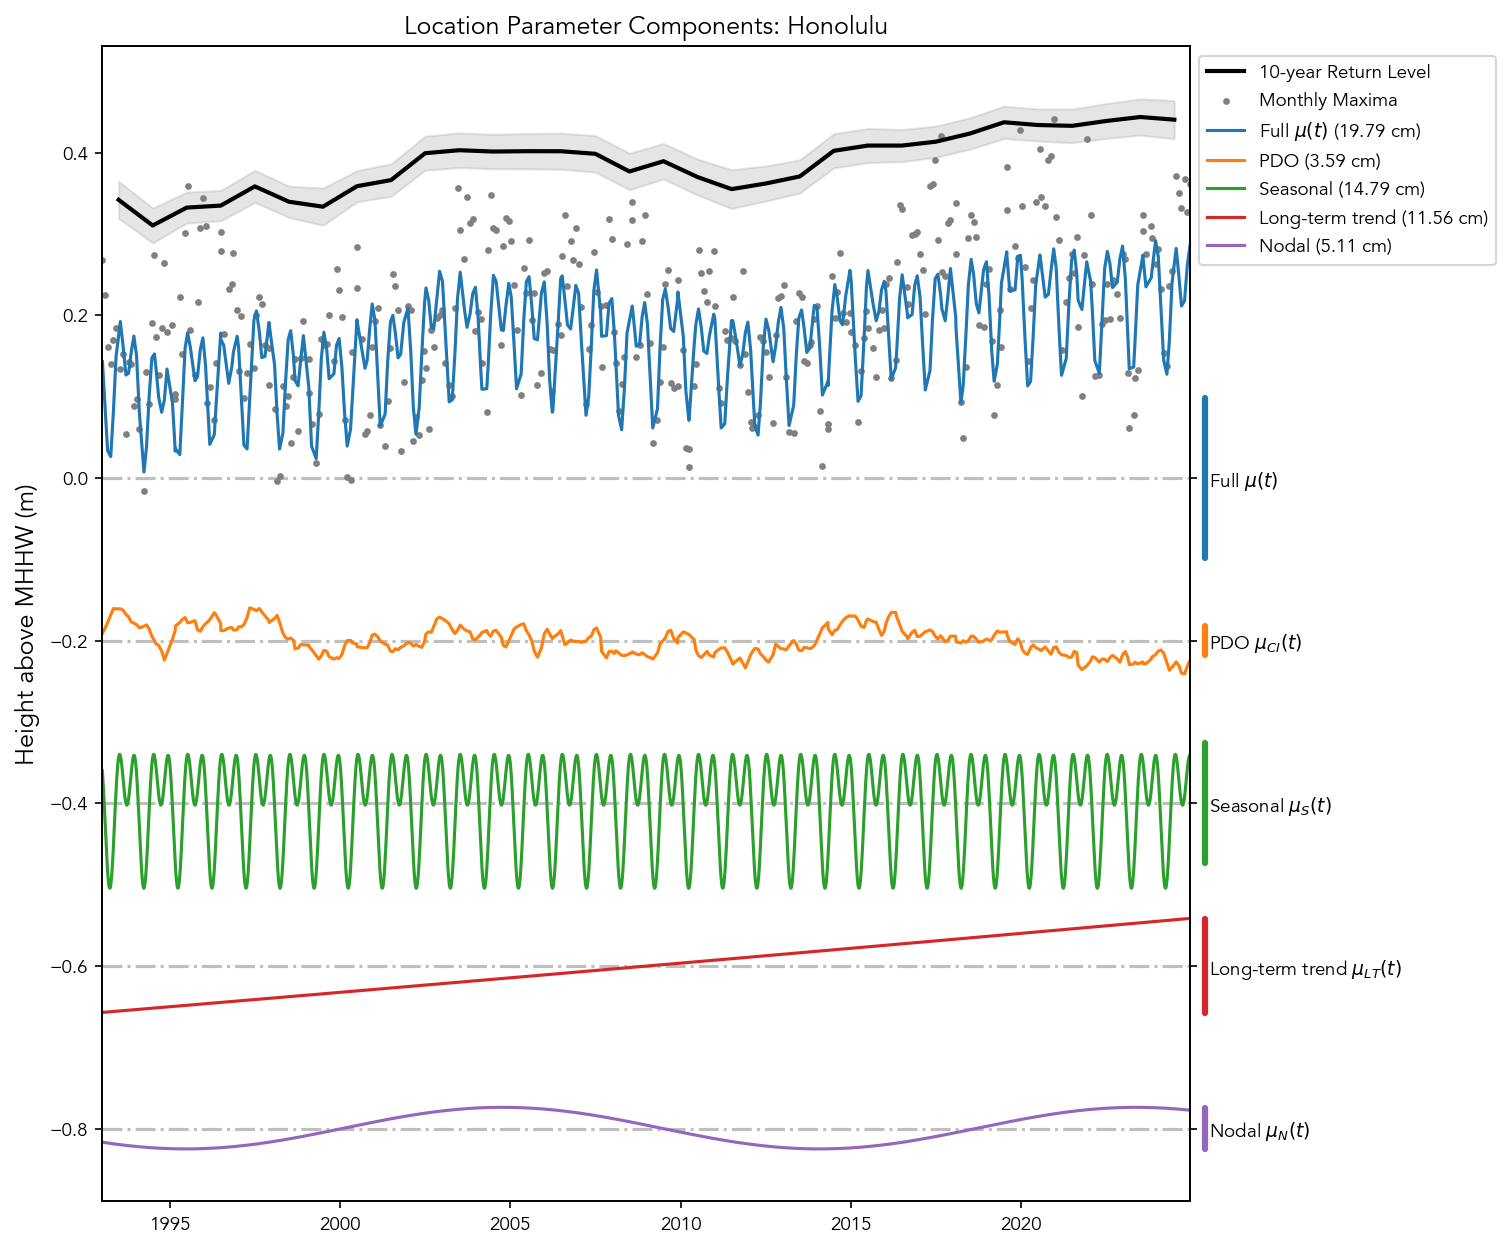

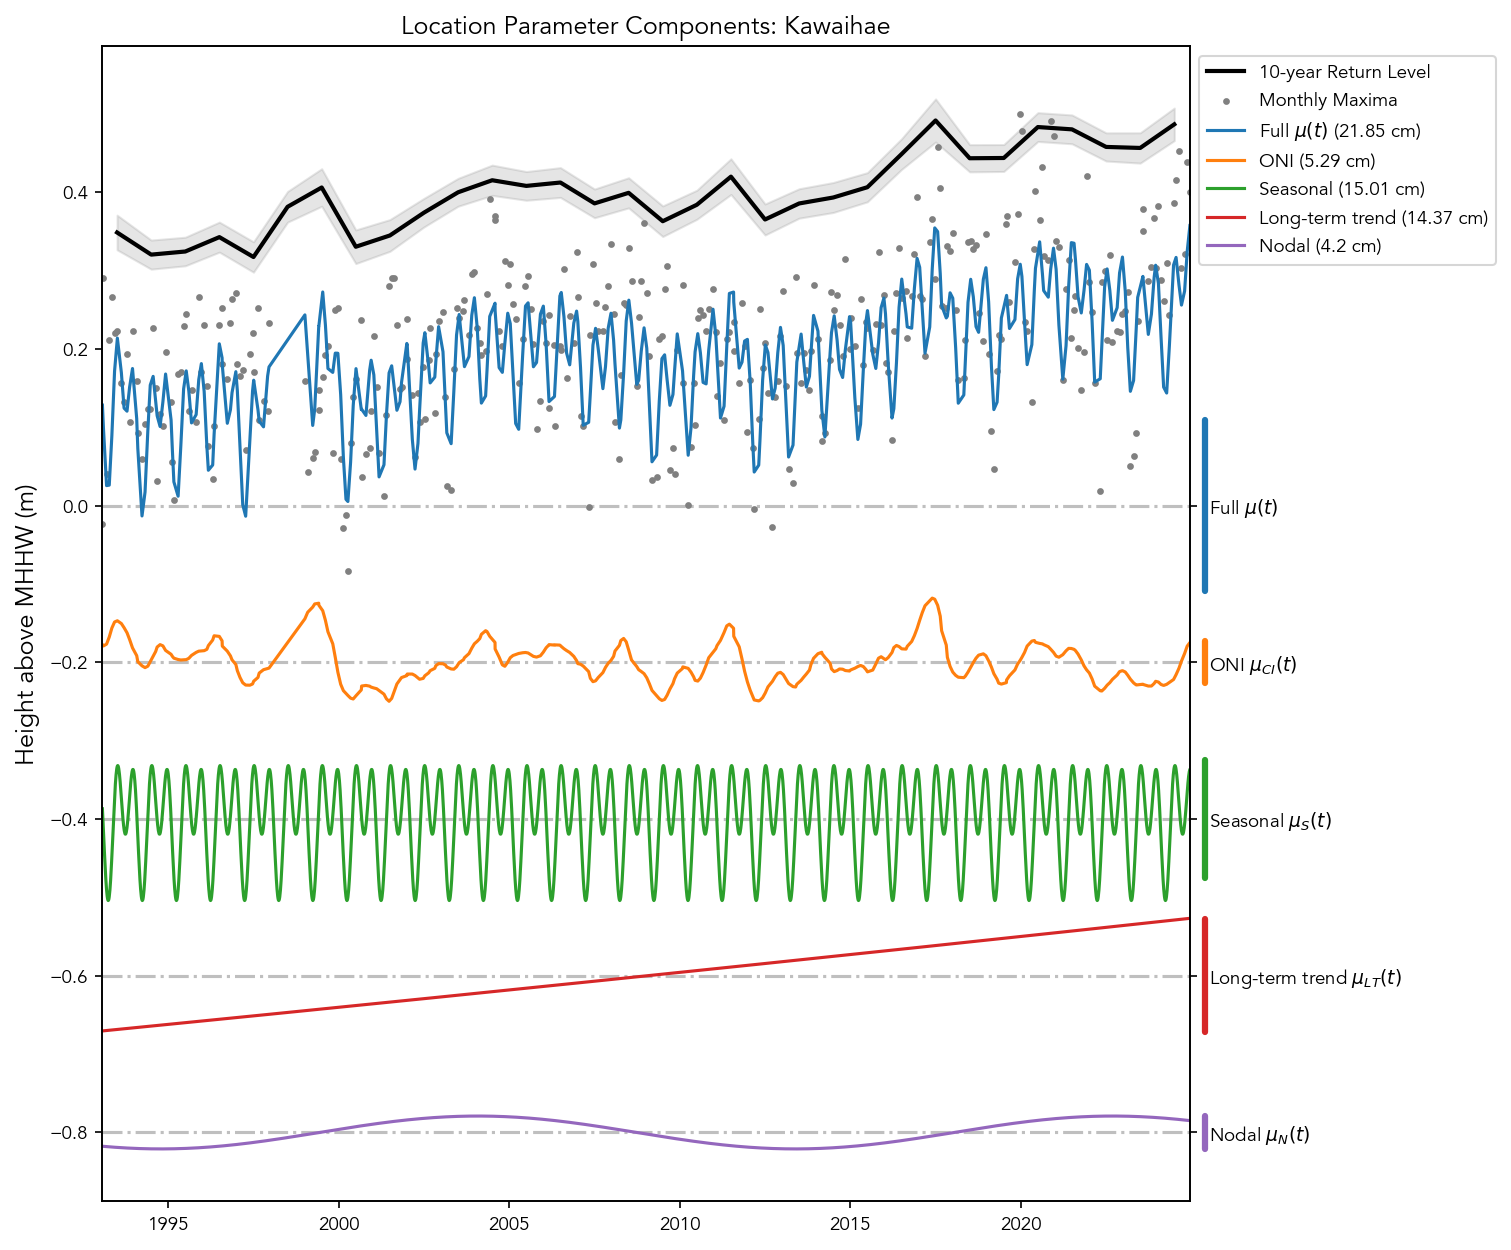

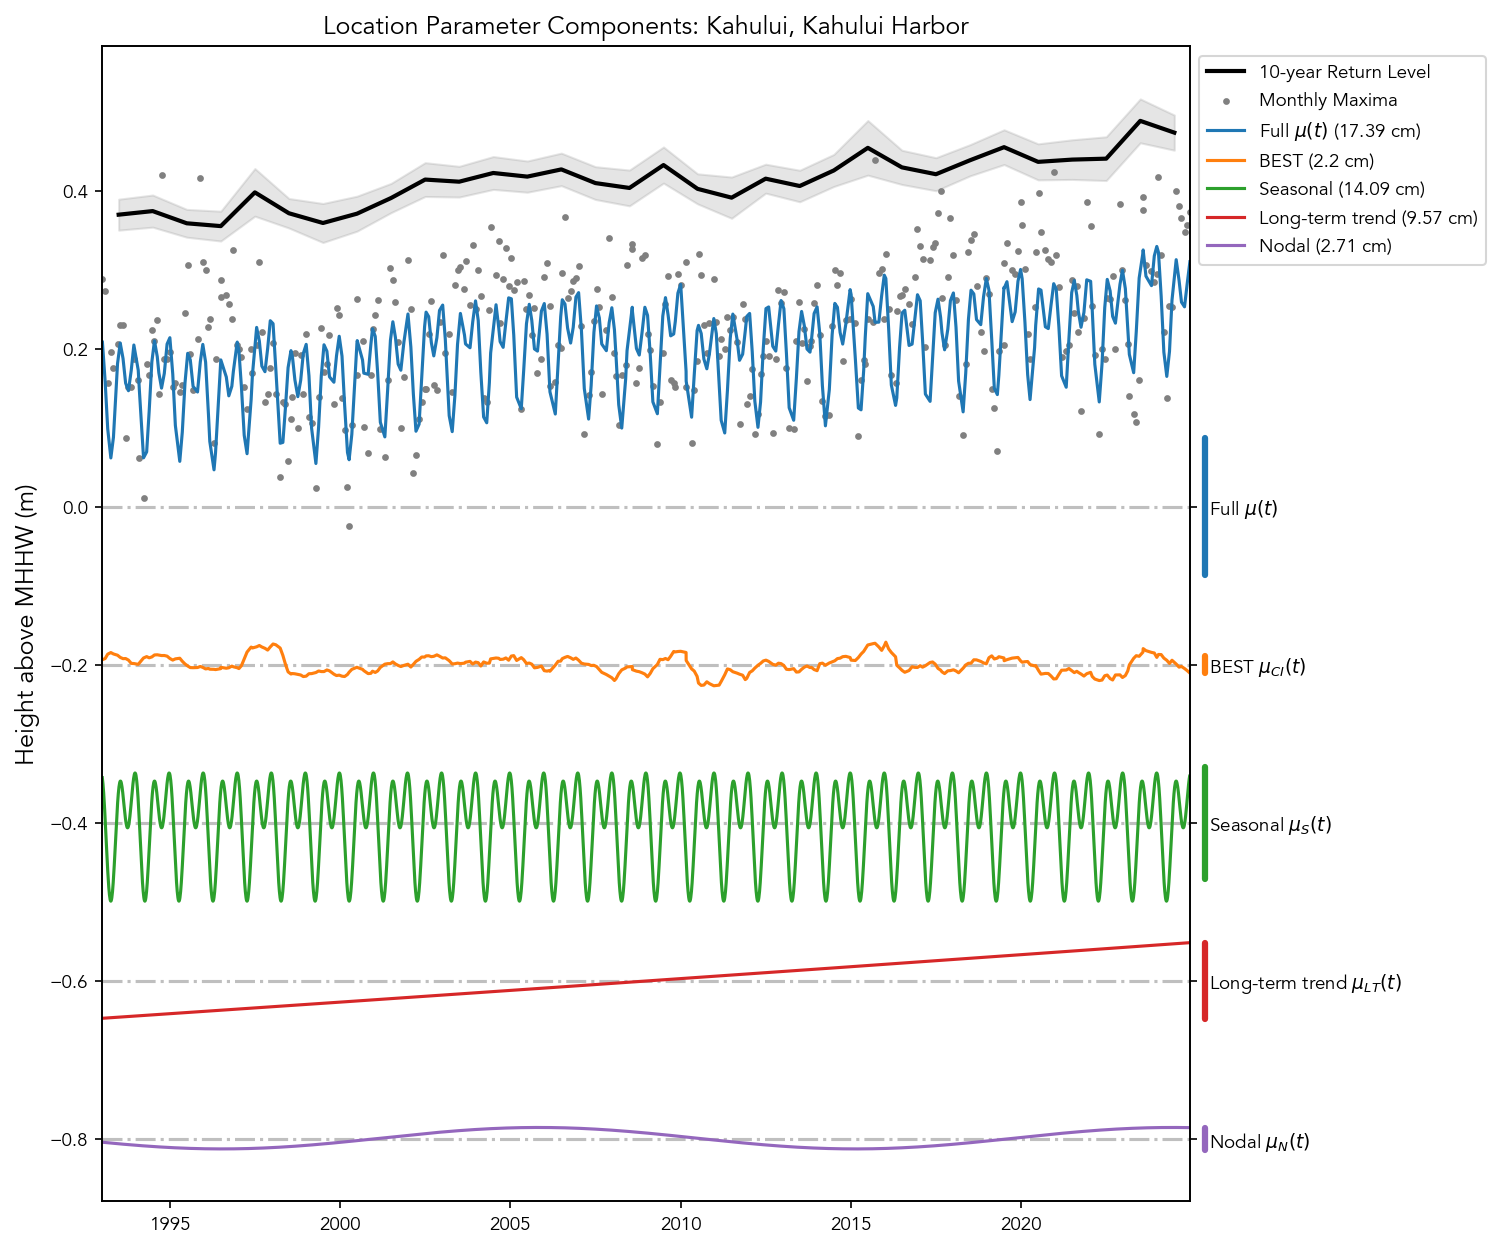

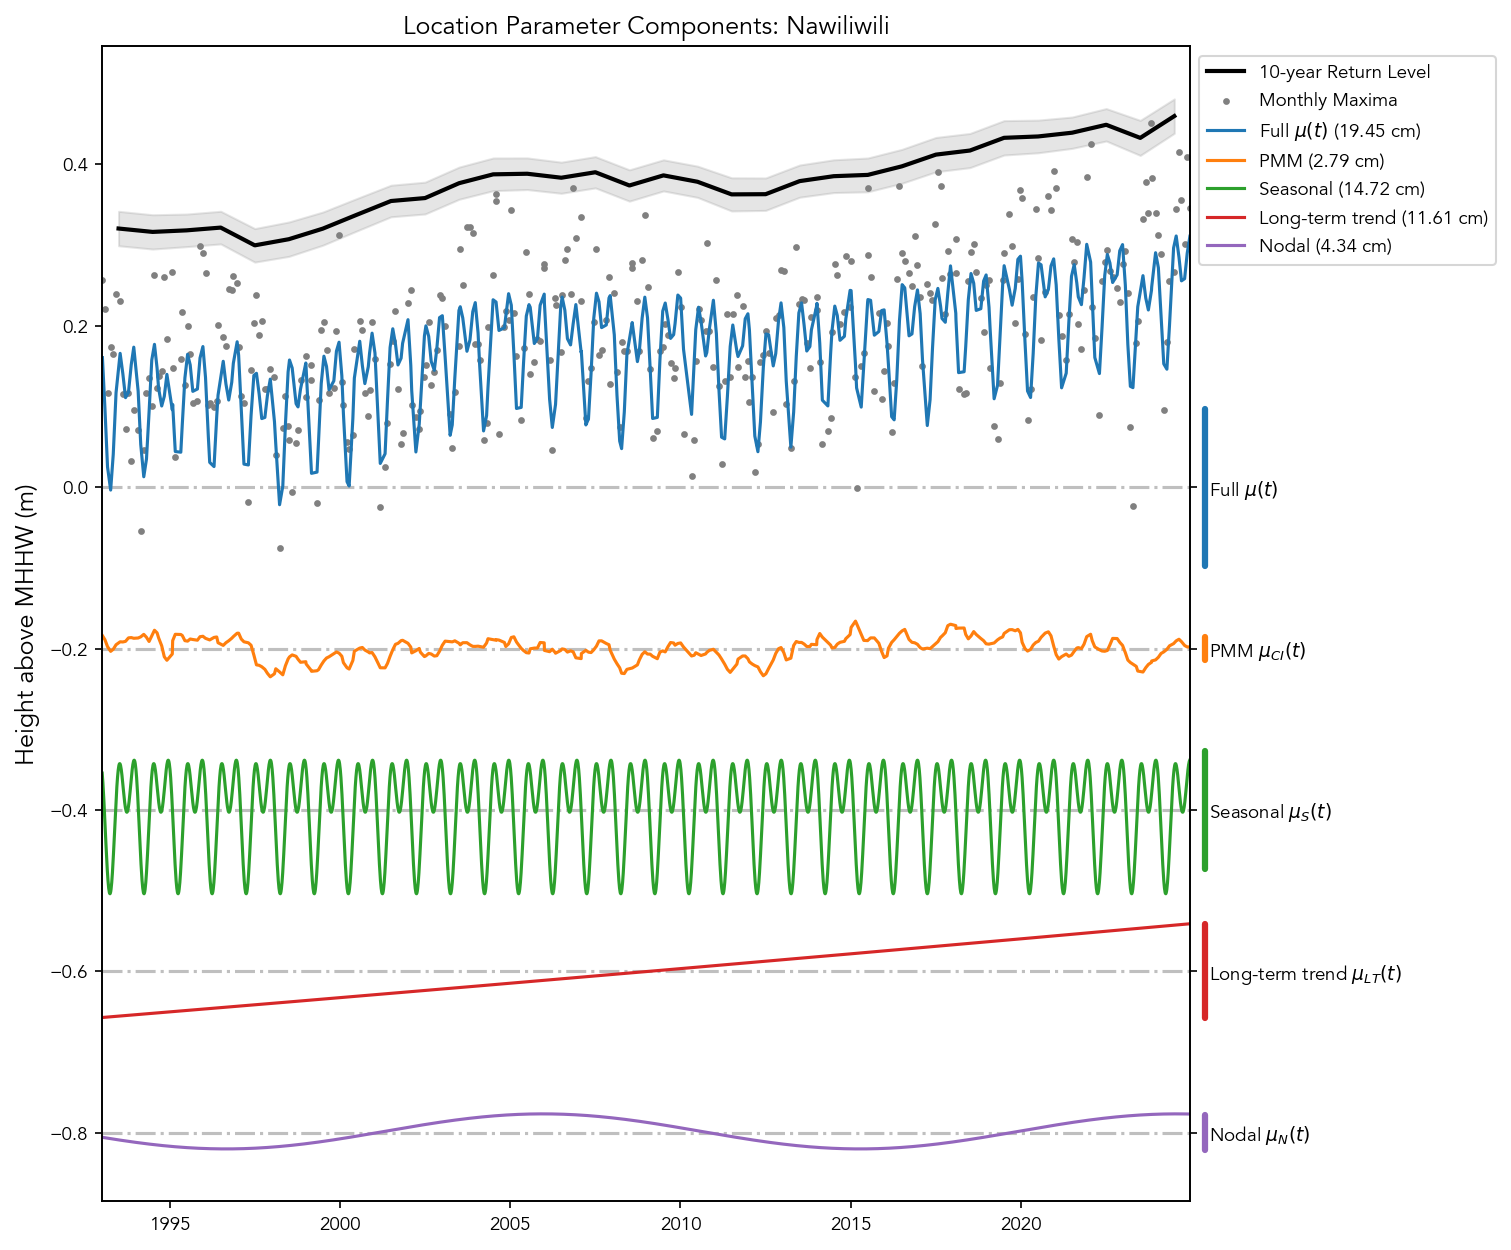

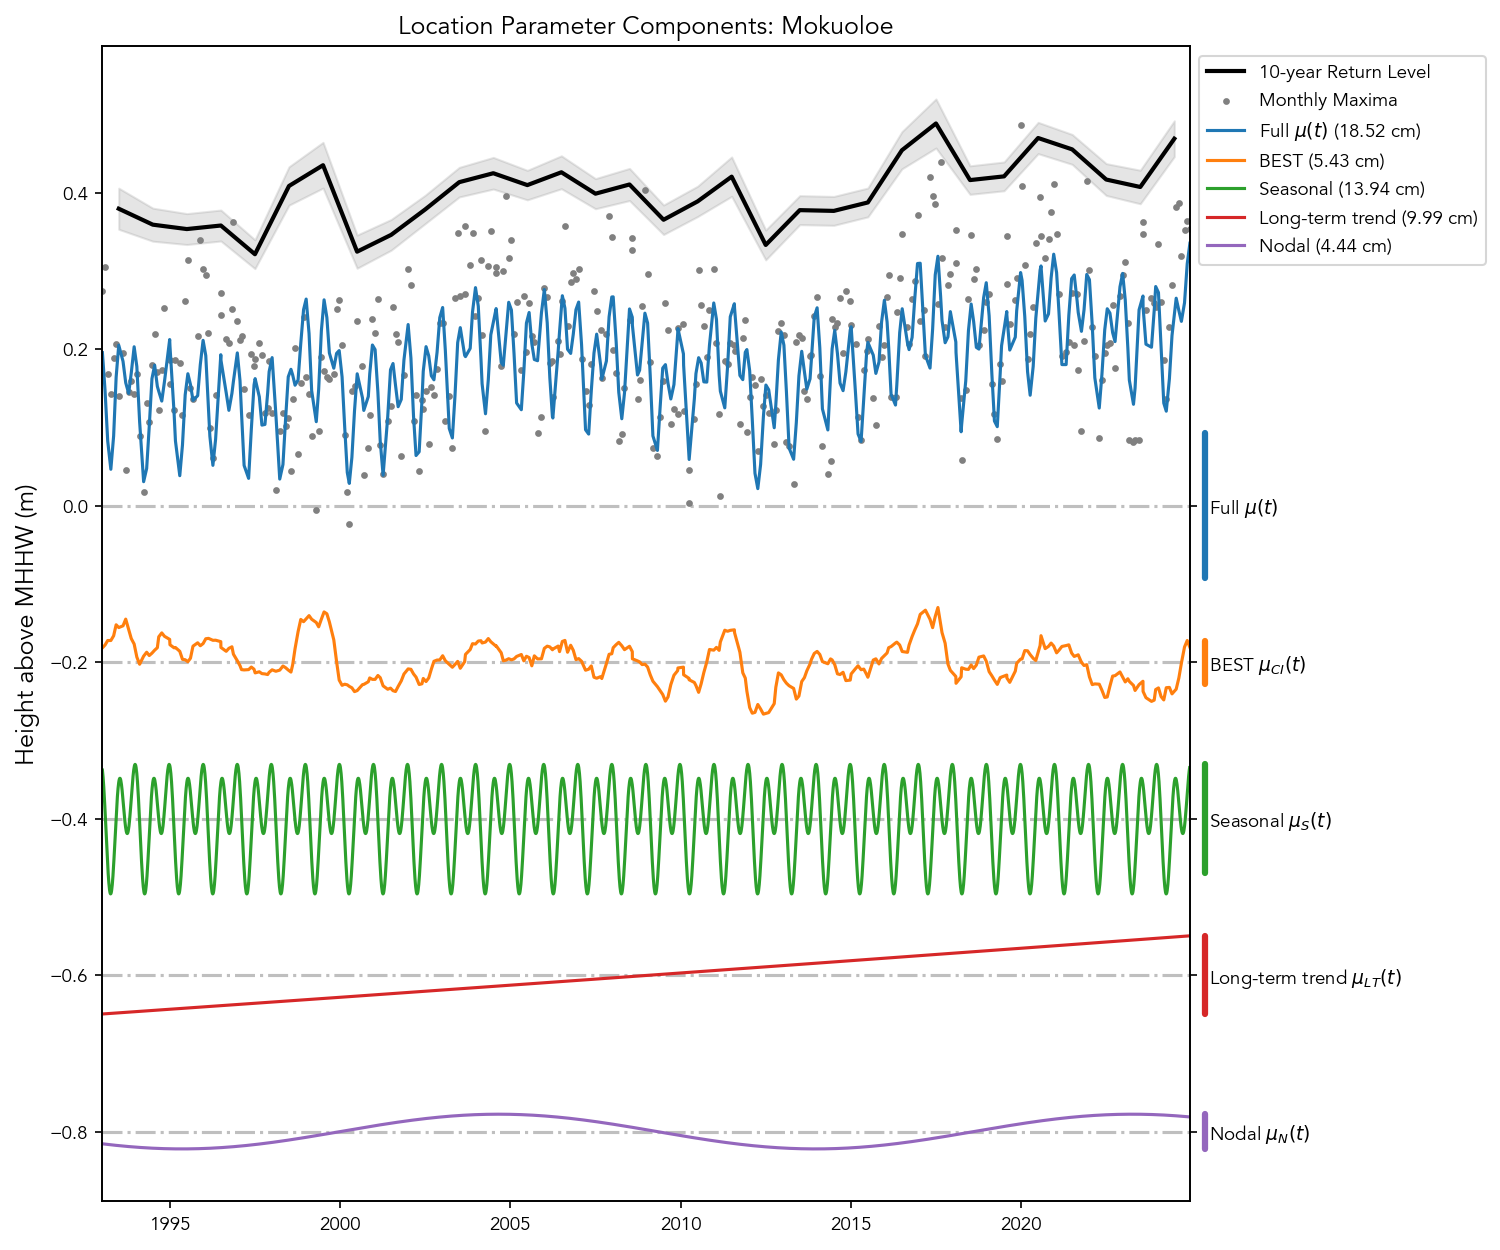

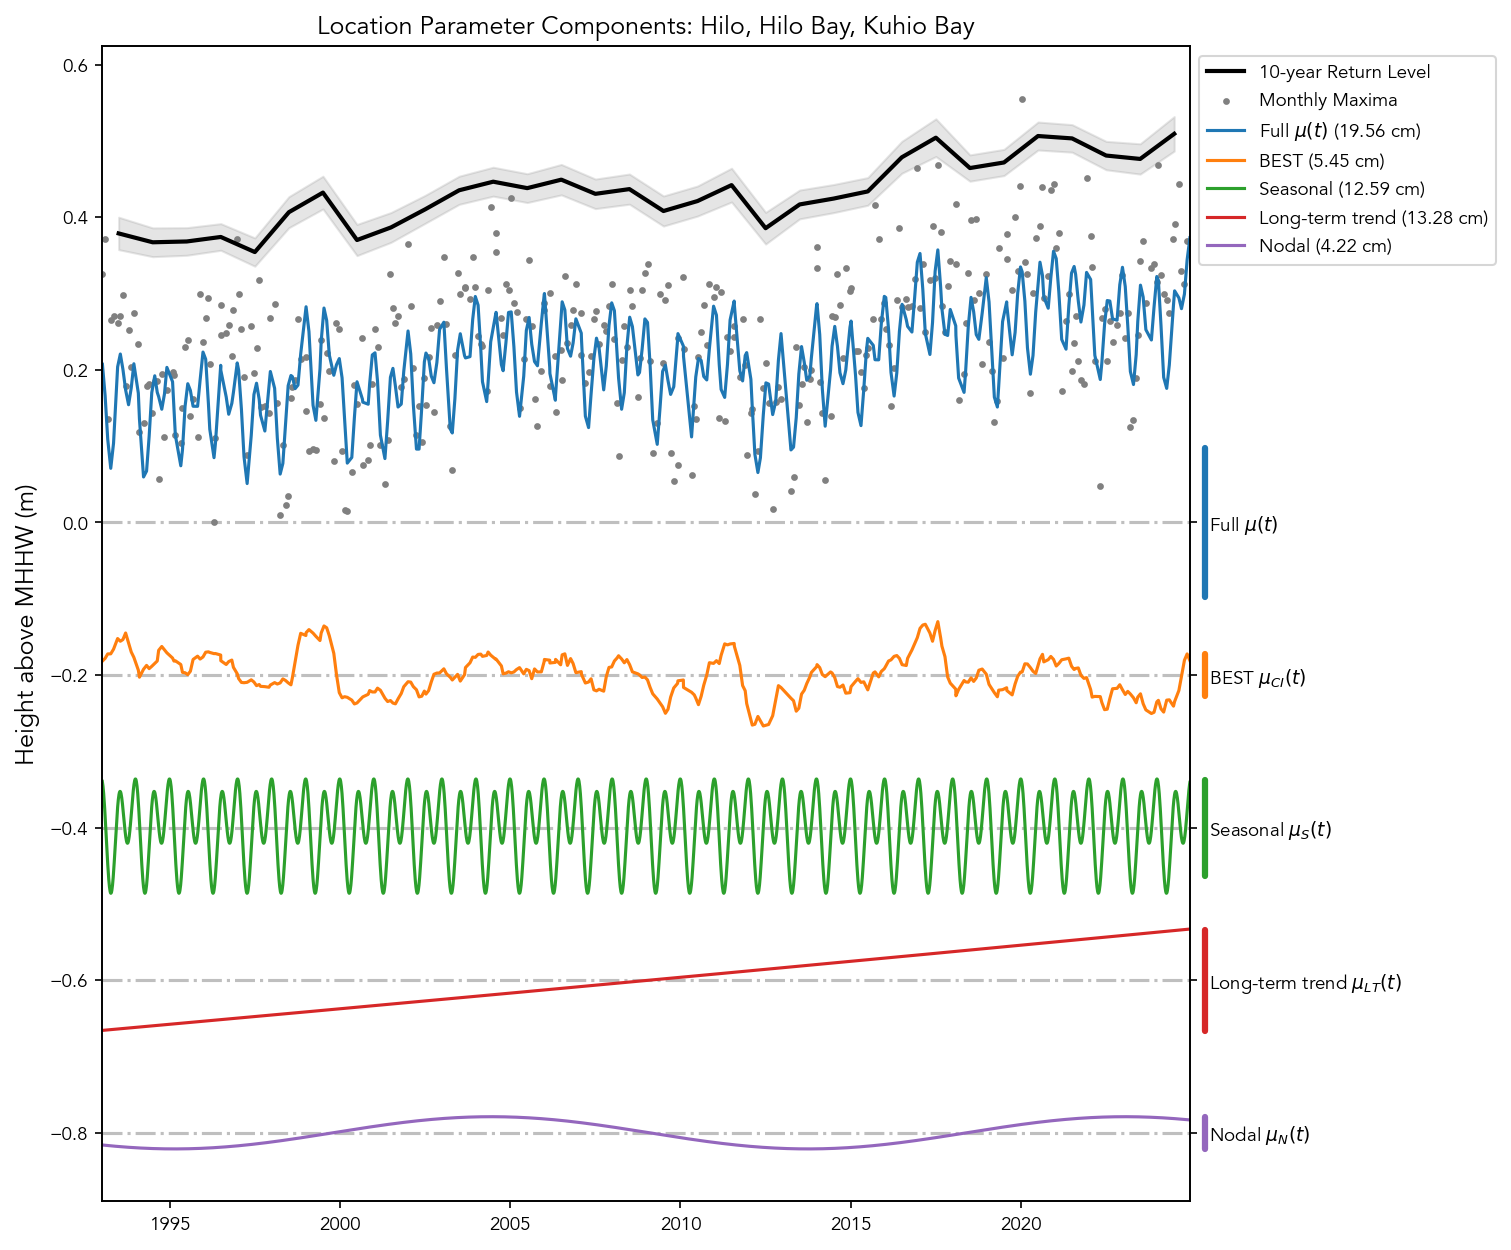

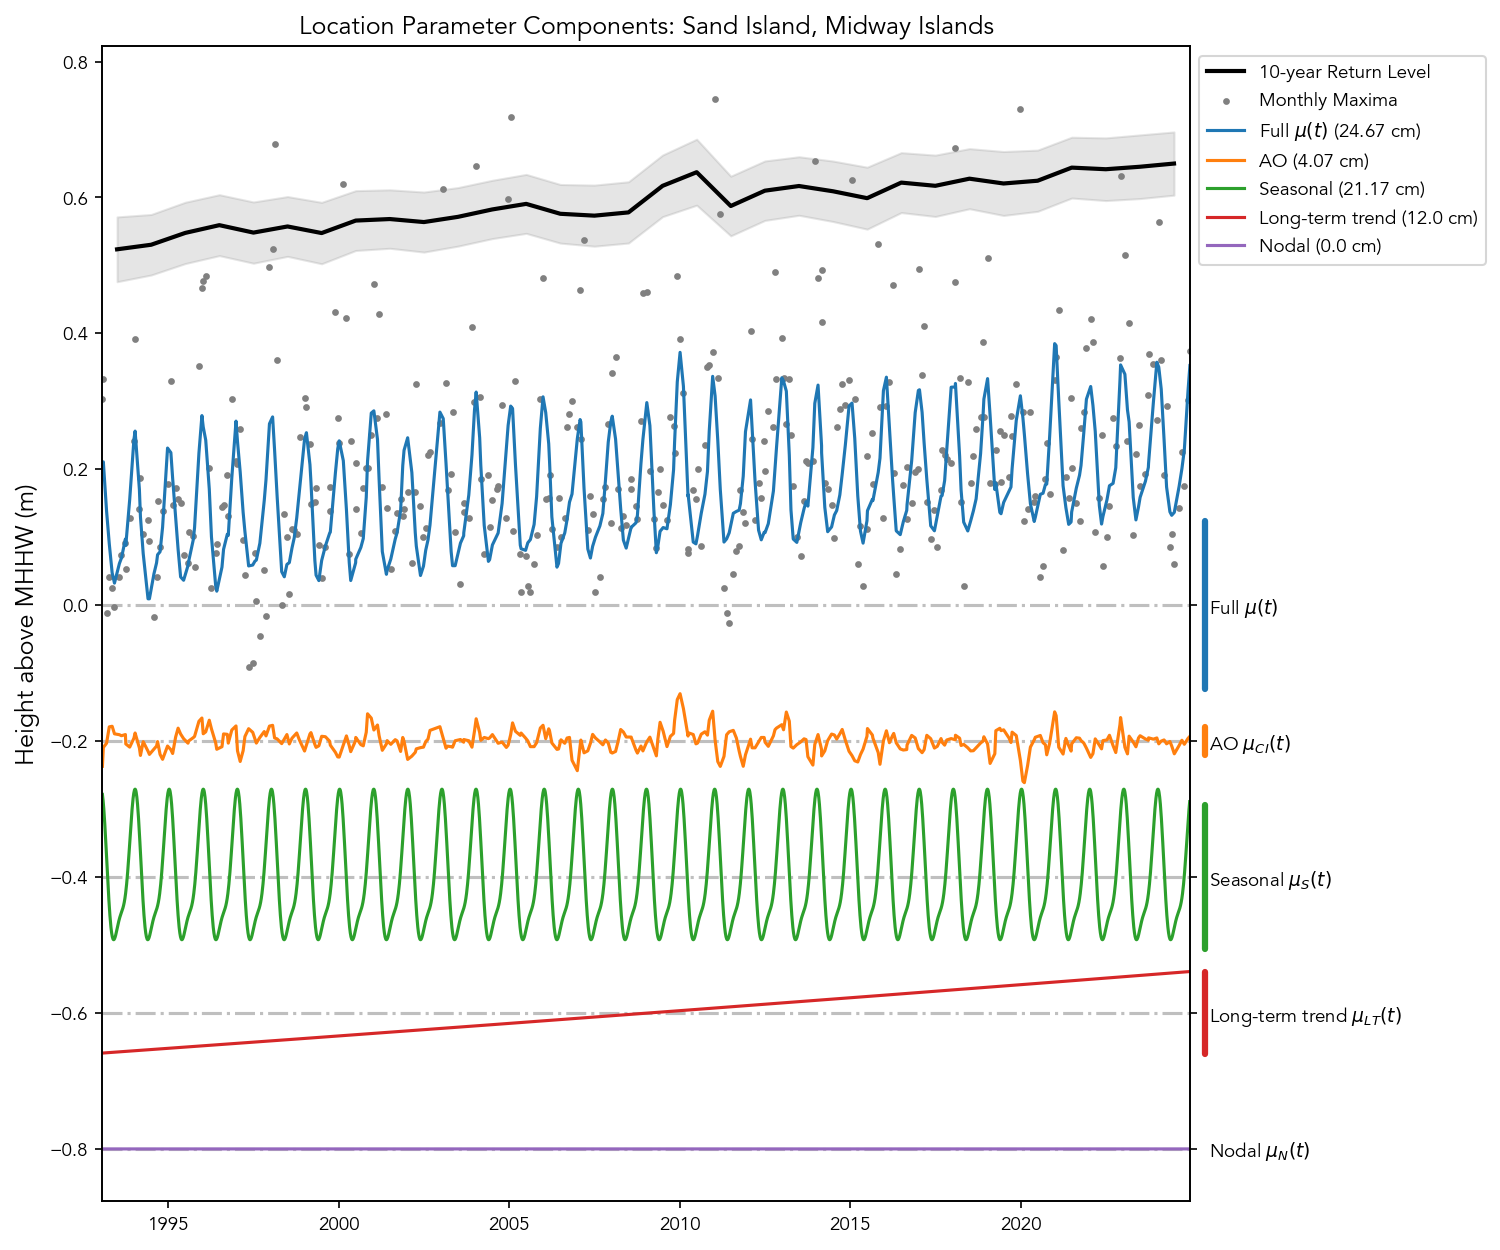

In [75]:
for stationID in stationIDs:

    # read the json file for best model
    jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
    with open(jsonpath, 'r') as f:
        output = json.load(f)
        modelInfo = output['modelInfo']
        params = output['w']
        x = output['x']
        
    time = modelInfo['year0'] + pd.Series(modelInfo['t'])

    w = helpers.adjust_w_for_plotting(x, params)
    modelType = 'RL_best.nc'
    model = xr.open_dataset(Path(dirs['model_output_dir']) / str(stationID) / modelType)
    fig, amps, ax = make_component_figure(w, modelInfo, model, time)

    #save the figure
    savename = 'LocationComponents_' + model.attrs['station_name'] + '.png'
    filename = Path(dirs['output_dir']) / savename
    fig.savefig(filename, bbox_inches='tight')

    # save amps to a json file
    amps_json = Path(dirs['model_output_dir']) / str(stationID) / 'location_param_component_amps.json'
    with open(amps_json, 'w') as f:
        json.dump(amps, f)



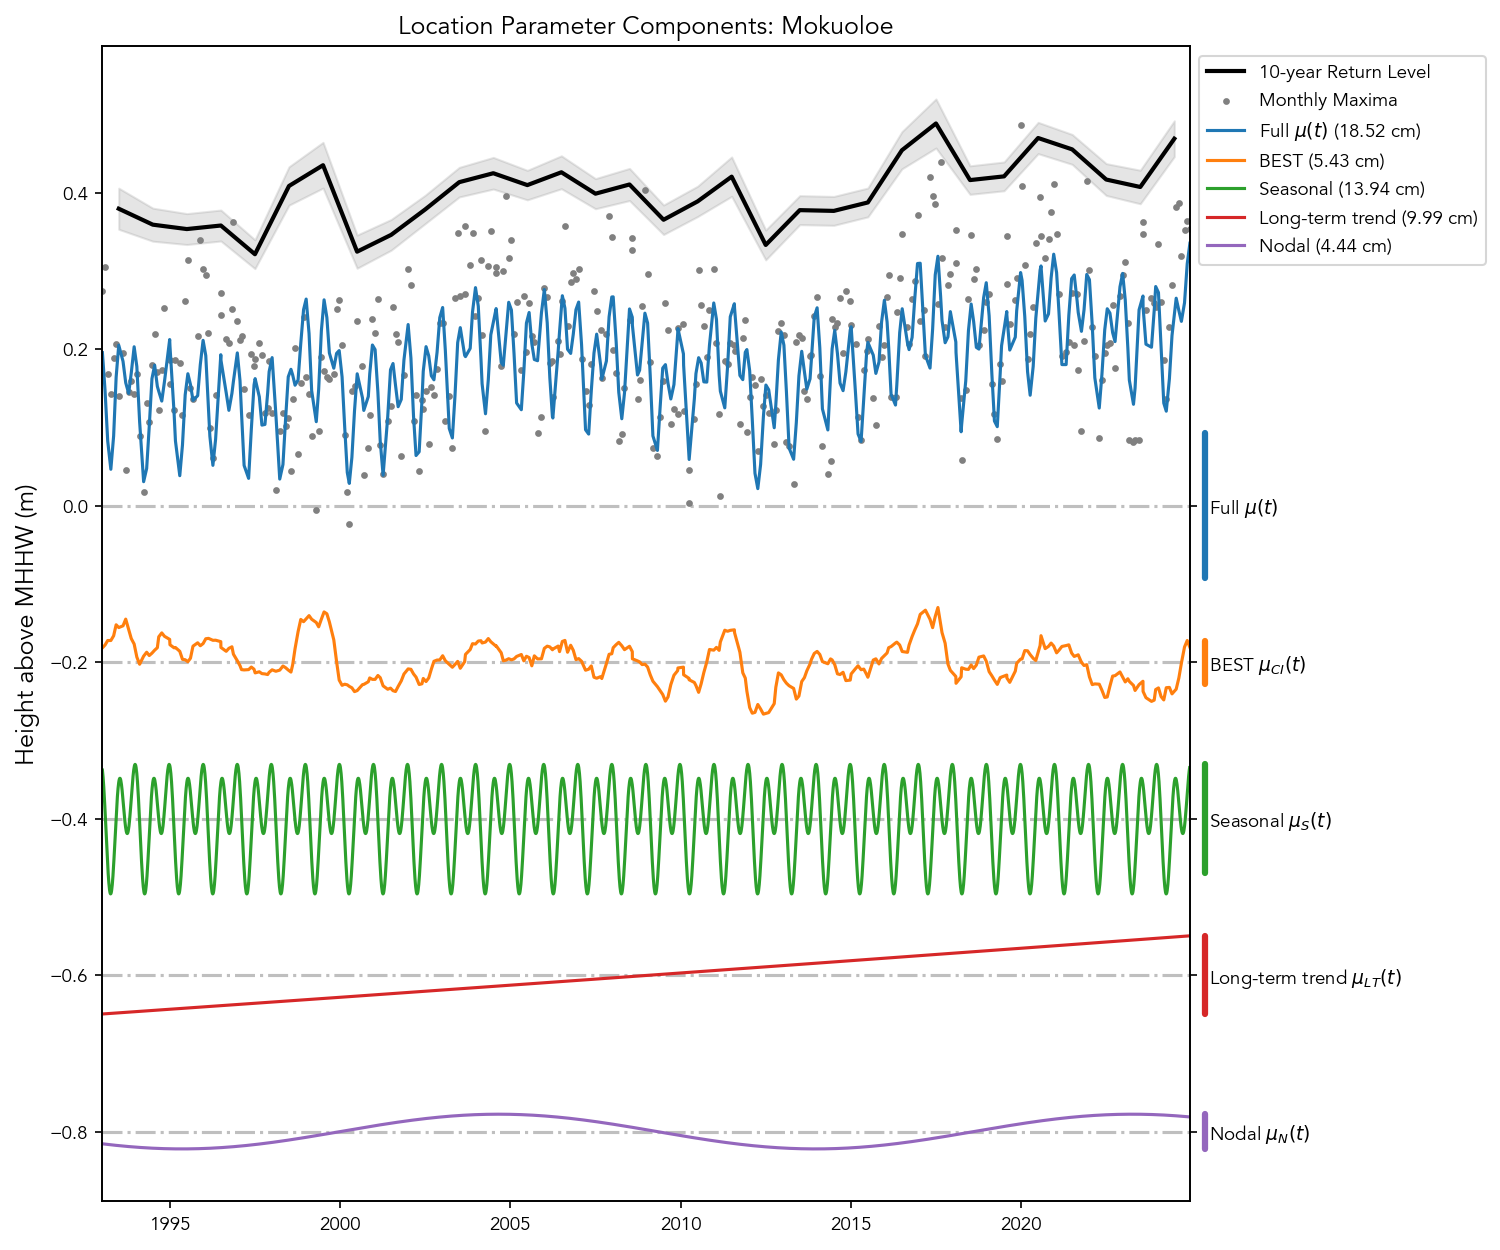

In [89]:
stationID = int(stationIDs[4])

# read the json file for best model
jsonpath = Path(dirs['model_output_dir']) / str(stationID) / 'best_params.json'
with open(jsonpath, 'r') as f:
        output = json.load(f)
        modelInfo = output['modelInfo']
        params = output['w']
        x = output['x']
        
time = modelInfo['year0'] + pd.Series(modelInfo['t'])

w = helpers.adjust_w_for_plotting(x, params)
modelType = 'RL_best.nc'
model = xr.open_dataset(Path(dirs['model_output_dir']) / str(stationID) / modelType)
fig, amps, ax = make_component_figure(w, modelInfo, model, time)

glue("location_components",fig,display=False)
glue("station",model.attrs['station_name'],display=False)

{glue:figure}
:name: "location_components"

Location parameter components for the {glue:text}`station` tide gauge.

## Plot components by station

The following code can only be run after all gauges have been modeled!

In [76]:
# get all location_parms_component_amp.json files and combine them into one
amps = {}

for stationID in stationIDs:
    amps_json = Path(dirs['model_output_dir']) / str(stationID) / 'location_param_component_amps.json'
    with open(amps_json, 'r') as f:
        amps[stationID] = json.load(f)


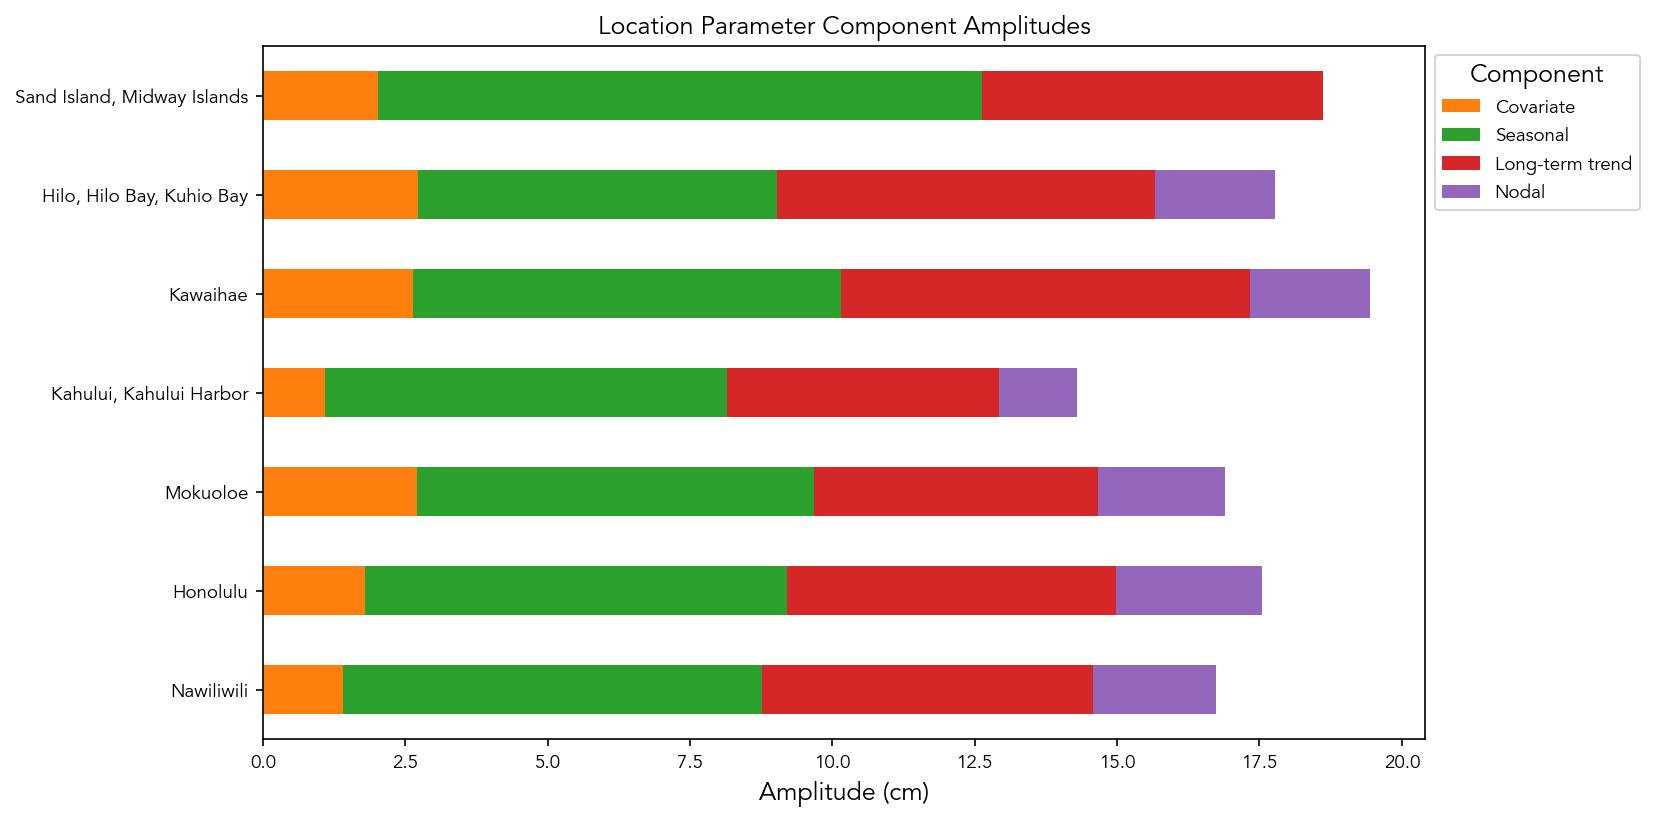

In [77]:
# Plot df as stacked bar chart ignoring the full component
# Turn amps into a dataframe
df = pd.DataFrame(amps).T
df.drop('Full', axis=1,inplace=True)

# Reorder columns to match above plot
df = df[['Covariate','Seasonal', 'Long-term trend',  'Nodal']]
#rename 'Covariate' to 'BEST (19-month lag)'
# df = df.rename(columns={'Covariate':'BEST (19-month lag)'})
df = df.sort_index()

# conver the data colums to cm and round to 2 decimal places
df = df.apply(lambda x: x*100).round(2)

# add station names to the dataframe
df['Station Name'] = station_names.values()


# Plot the data with amplitudes on the x-axis
df.plot(kind='barh', stacked=True, figsize=(10, 6), color=plt.cm.tab10.colors[1:])
plt.title('Location Parameter Component Amplitudes')
plt.xlabel('Amplitude (cm)')
plt.legend(title='Component', loc='upper left', bbox_to_anchor=(1, 1))

# replace the x-axis with the station names
plt.yticks(np.arange(len(df.index)), df['Station Name']);

# save the plot
savename = Path(dirs['output_dir']) / 'location_param_component_amps.png'
plt.savefig(savename, bbox_inches='tight')

glue("location_param_component_amps",plt.gcf(),display=False)


```{glue:figure} location_param_component_amps
:name: "location_param_component_amps"
Bar plot showing the amplitude of individual covariate contributions (seasonal, long-term trend, climate variability and nodal tidal cycle) to sea level in the location parameter. The amplitude of each factor is displayed in centimeters. The covariate shown here corresponds to the best fit climate covariate to the nonstationary GEV model.

```

## Plot a map of covariate contributions
Here we'll look at the influence of the climate covariate in the form of a map. First we'll extract the amplitudes of the covariate from every station we've analyzed.


In [78]:
# load rsl data
with xr.open_dataset(dirs['data_dir'] / 'rsl_daily_hawaii.nc') as rsl:
    df = rsl[['lat', 'lon', 'station_name', 'station_id']].to_dataframe().reset_index()
    pass

# Initialize ampCI as a vector of zeros
df['ampCI'] = 0

# Assign ampCI values using the station_id column with vectorization, where possible
df['ampCI'] = df['station_id'].map(lambda sid: amps.get(int(sid), {}).get('Covariate', 0))

# Initialize modelCI with 'None' as default
df['modelCI'] = 'None'

# Function to get modelCI, with improved error handling
def get_model_ci(station_id):
    fpath = Path(dirs['model_output_dir']) / str(station_id) / 'RL_best.nc'
    try:
        with xr.open_dataset(fpath) as model:
            return model.attrs.get('covariate', 'None')
    except FileNotFoundError:
        print(f'No model found for stationID: {station_id}, skipping...')
        return 'None'
    except Exception as e:
        print(f'Error processing {station_id}: {e}')
        return 'None'

# Apply the function to the DataFrame (efficient vectorized operation)
df['modelCI'] = df['station_id'].apply(get_model_ci)


Next we'll plot up our map.

In [79]:
from matplotlib import colors, cm
import sys, pathlib
sys.path.append(str(pathlib.Path('../../functions').resolve()))
import plotting_functions as pf
from matplotlib.lines import Line2D

In [80]:
df['ampCI'] = 100*df['ampCI'] # put ampCI in centimeters
df['ampCI'] = df['ampCI'].round(2)

# make all ampCI values if zero 0.05
df['ampCI'] = df['ampCI'].replace(0, 0.3)

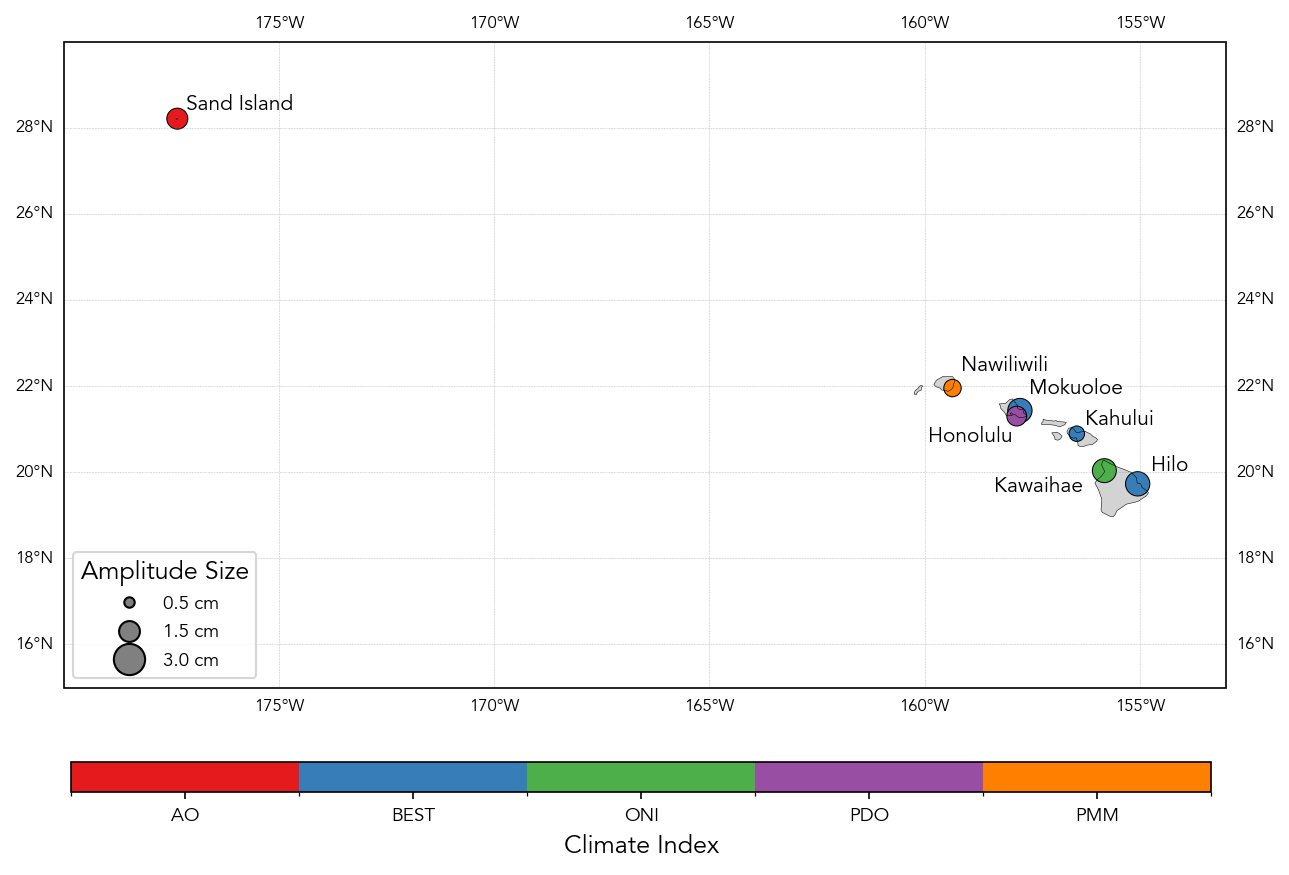

In [81]:

# Separate the "None" entries from the rest of the data
df_none = df[df['modelCI'] == 'None']  # Entries where modelCI is 'None'
df_filtered = df[df['modelCI'] != 'None']  # All other entries

# Use tab10 colormap for colors (excluding 'None')
cmap = plt.get_cmap('Set1')
color_dict = {index: cmap(i) for i, index in enumerate(np.unique(df_filtered['modelCI']))}

# Map the climate indices to numerical values for the colorbar
index_mapping = {index: i for i, index in enumerate(np.unique(df_filtered['modelCI']))}
mapped_indices = [index_mapping[ci] for ci in df_filtered['modelCI']]

# Create a colormap without "None"
norm = colors.BoundaryNorm(boundaries=np.arange(len(np.unique(df_filtered['modelCI'])) + 1) - 0.5, 
                               ncolors=len(np.unique(df_filtered['modelCI'])))

fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

# Call plot_thin_map_hawaii to create the figure and axis
pf.plot_thin_map_hawaii(ax)

sizefac = 50
# Plot each station with varying color (based on climate index) and size (based on amplitude)
scatter = ax.scatter(df_filtered['lon'], df_filtered['lat'], 
                     c=mapped_indices, cmap=cmap, 
                     norm=norm, s=sizefac * df_filtered['ampCI'],
                     edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

# Plot the "None" stations in gray (fixed color)
ax.scatter(df_none['lon'], df_none['lat'], 
           color='gray', s=sizefac * df_none['ampCI'], 
           edgecolor='black', linewidth=0.5, transform=ccrs.PlateCarree())

dfInfo = pf.get_stationinfo(dirs['data_dir'])
dfInfo['station_id'] = dfInfo['station_id']

#change the font color to black if the station is in the df_filtered
dfInfo['fontcolor'] = np.where(dfInfo['station_id'].isin(df_filtered['station_id']), 'black', 'gray')

# Add an axes for the colorbar
cax = fig.add_axes([0.13, 0.21, 0.76, 0.02])  

# dfInfo
# Add text labels with adjusted offsets and horizontal alignment
for i, name in enumerate(dfInfo['station_name']):
    ax.text(dfInfo['lon'][i] + dfInfo['offsetlon'][i], dfInfo['lat'][i] + dfInfo['offsetlat'][i], name, 
            ha=dfInfo['ha'][i], fontsize=10, transform=ccrs.PlateCarree(),rotation=0, color = dfInfo['fontcolor'][i])

# Add a colorbar for the climate index
cbar = plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, orientation='horizontal')
cbar.set_ticks(np.arange(len(np.unique(df_filtered['modelCI']))))
cbar.set_ticklabels(np.unique(df_filtered['modelCI']))
cbar.set_label('Climate Index')


# Amplitude size legend
sizes = [50, 100, 150]
size_labels = ["0.5 cm", "1.5 cm", "3.0 cm"]  
size_legend_elements = [Line2D([0], [0], marker='o', color='none', label=label, 
                               markerfacecolor='gray', markersize=size / 10) 
                        for size, label in zip(sizes, size_labels)]
ax.legend(handles=size_legend_elements, title="Amplitude Size", loc="lower left")

# change axes limits to ensure all stations are visible
ax.set_ylim(15, 30)
ax.set_xlim(-180, -153)


# save the figure
savename = Path(dirs['output_dir']) / 'SL_contributions_map.png'
plt.savefig(savename, dpi=300, bbox_inches='tight')

glue("CI_map",fig,display=False)


```{glue:figure} CI_map
:name: "CI_map"

Map of dominant climate indices in the Hawaiian Islands region. The size of each circle at a given tide gauge represents the amplitude of the climate covariate in the location parameter of nonstationary extremes. ENSO-type climate indices are are well-represented with amplitudes between 1.5-3 cm.  
```

## Plot a map of more GEV components

In [82]:
#turn station_names into a dict
station_names_dict = {stationID: name for stationID, name in zip(stationIDs, station_names)}

In [83]:
# make a csv of the parameters in the best model, using best_params.json
best_params_list = []

#load rsl_hourly
rsl_hourly = xr.open_dataset(Path(data_dir) / "rsl_hawaii_noaa.nc")

for station_id in stationIDs:  
    params_file = model_output_dir / str(station_id) / 'best_params.json'
    if params_file.exists():
        with open(params_file, 'r') as f:
            best_params = json.load(f)

            wbest = adjust_w_for_plotting(best_params['x'], best_params['w'])

            b0, a0, xi, b1, b2, b3, b4, b5, b6 = wbest[:9] # basics + seasonal cycle
            bLT, bCI, aCI, bN1, bN2 = wbest[9:]  # added fun

        best_params_list.append({
            'station_id': station_id,
            'station_name': station_names_dict[station_id],
            'latitude': rsl_hourly.sel(station_id = str(station_id)).lat.item(),
            'longitude': rsl_hourly.sel(station_id = str(station_id)).lon.item(),
            'mhhw': best_params['modelInfo']['STNDtoMHHW'],
            'cvte': best_params['modelInfo']['covariateName'],
            'b0': b0,
            'a0': a0,
            'xi': xi,
            'b1': b1,
            'b2': b2,
            'b3': b3,
            'b4': b4,
            'b5': b5,
            'b6': b6,
            'bLT': bLT,
            'bCI': bCI,
            'aCI': aCI,
            'bN1': bN1,
            'bN2': bN2
        })

In [84]:
# turn best_params_list into a dataframe
best_params_df = pd.DataFrame(best_params_list)
best_params_df

,station_id,station_name,latitude,longitude,mhhw,cvte,b0,a0,xi,b1,b2,b3,b4,b5,b6,bLT,bCI,aCI,bN1,bN2
0,1612340,1611400,21.303333,202.13547,1.741,PDO,1.854747,0.064136,-0.227742,-0.003501,-0.050969,0.053137,-0.006058,0.0,0.0,0.001893,0.017954,0.000000,-0.017207,-0.018919
1,1617433,1612340,20.036600,204.17060,1.444,ONI,1.555855,0.069590,-0.299183,-0.004463,-0.042168,0.061674,-0.005798,0.0,0.0,0.002770,0.026435,0.000000,-0.017312,-0.011852
2,1615680,1612480,20.894945,203.53100,1.422,BEST,1.573509,0.058502,-0.183016,0.010108,-0.045604,0.051597,0.011042,0.0,0.0,0.001848,0.010985,0.002531,-0.005026,-0.012601
3,1611400,1615680,21.954400,200.64390,1.255,PMM,1.365173,0.062503,-0.239464,0.000849,-0.050558,0.053398,-0.002845,0.0,0.0,0.002556,0.013967,0.000000,-0.007185,-0.020487
4,1612480,1617433,21.433056,202.21000,1.536,BEST,1.667909,0.063885,-0.254276,0.010554,-0.038179,0.057144,0.004685,0.0,0.0,0.001821,0.027139,0.006777,-0.015542,-0.015824
5,1617760,1617760,19.730278,204.94444,1.927,BEST,2.072964,0.070575,-0.273579,0.011640,-0.031747,0.051953,0.011089,0.0,0.0,0.001944,0.027234,0.000000,-0.015860,-0.013926
6,1619910,1619910,28.211666,182.64000,1.206,AO,1.316415,0.092454,-0.065992,0.101209,-0.000522,0.024785,0.018661,0.0,0.0,0.002734,-0.020328,0.000000,0.000000,0.000000


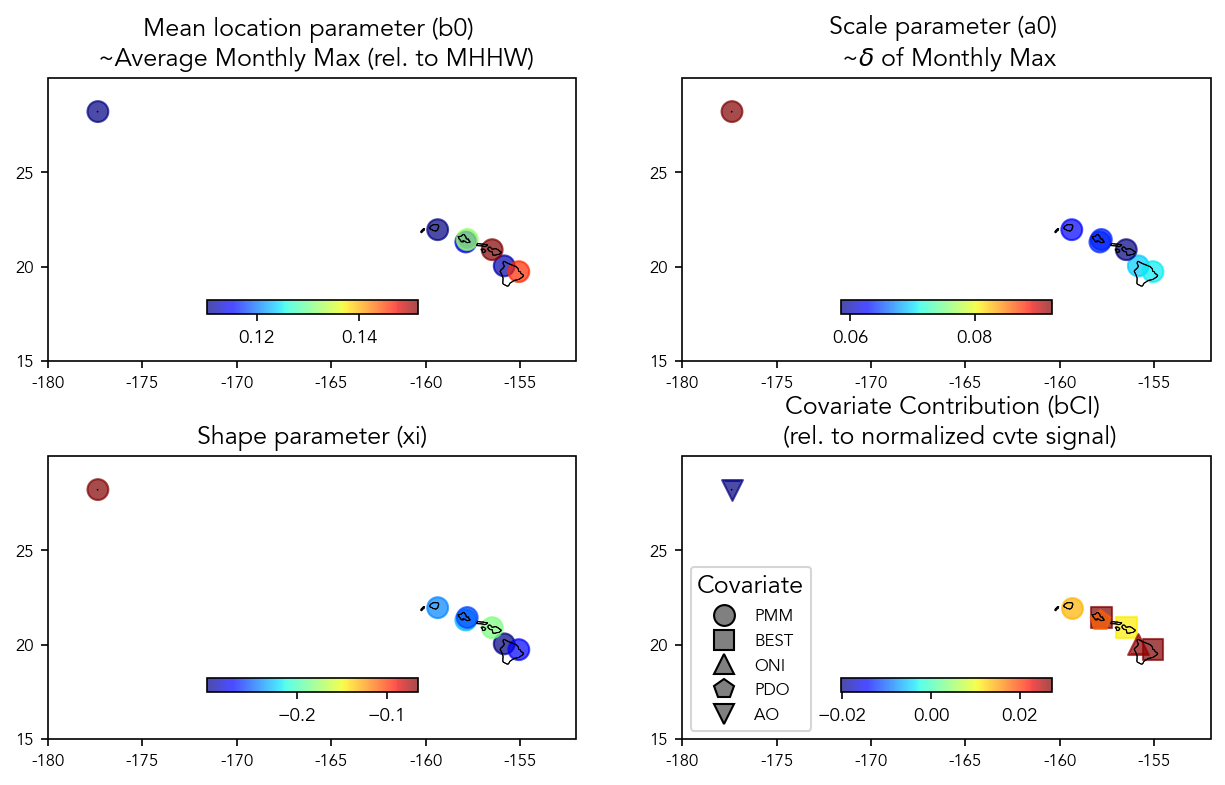

In [85]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
fig, axs = plt.subplots(2,2, figsize=(10,6), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=-180)})

axs = axs.flatten()

params_to_plot = ['b0', 'a0', 'xi', 'bCI']

for i, param in enumerate(params_to_plot):
    ax = axs[i]

    paramplot = best_params_df[param].astype(float)
    if i==0:
        # For b0, we want to plot it relative to the MHHW
        paramplot = paramplot - best_params_df['mhhw'].astype(float)

    if param != 'bCI':
        sc = ax.scatter(best_params_df['longitude'], best_params_df['latitude'],
                       c=paramplot,
                       cmap='jet', s=100, edgecolor=None, alpha=0.7, transform=ccrs.PlateCarree())
        
        cb_ax = inset_axes(ax, width='40%', height='5%', loc='lower center', borderpad=2.5)
        plt.colorbar(sc, cax=cb_ax, orientation='horizontal')

    if param == 'bCI':
        marker_dict = {'PMM': 'o', 'BEST': 's', 'ONI': '^', 'PDO': 'p', 'AO': 'v', 'PNA': 'd', 'TNA': '*'}
        legend_handles = []
        scatters = []
    
        # Get all bCI values for color normalization
        all_bCI = best_params_df['bCI'].astype(float)
        vmin, vmax = all_bCI.min(), all_bCI.max()
    
        for covariate, marker in marker_dict.items():
            subset = best_params_df[best_params_df['cvte'] == covariate]
            if not subset.empty:
                sc = ax.scatter(
                    subset['longitude'], subset['latitude'],
                    c=subset['bCI'].astype(float),
                    cmap='jet', s=100, marker=marker, edgecolor=None, alpha=0.7,
                    vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree(),
                    label=covariate
                )
                scatters.append(sc)
                legend_handles.append(
                    plt.Line2D([0], [0], marker=marker, color='w', label=covariate,
                               markerfacecolor='gray', markeredgecolor='black', markersize=10)
                )
    
        ax.legend(handles=legend_handles, title='Covariate', loc='lower left', fontsize=8)
        cb_ax = inset_axes(ax, width='40%', height='5%', loc='lower center', borderpad=2.5)
        # Use the first scatter for the colorbar (all use same vmin/vmax/cmap)
        plt.colorbar(scatters[0], cax=cb_ax, orientation='horizontal')

    ax.set_title(param)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([-200, -60, 0, 68], crs=ccrs.PlateCarree())
    
    # plt.colorbar(sc, cax=cb_ax, orientation='horizontal')

for ax in axs:
    ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
    ax.set_extent([-180, -152, 15,30], crs=ccrs.PlateCarree())
    ax.set_xticks(np.arange(-180, -152, 5), crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(15,30,5), crs=ccrs.PlateCarree())
    ax.set_xticklabels(np.arange(-180, -152, 5), fontsize=8)
    ax.set_yticklabels(np.arange(15,30,5), fontsize=8)

axs[0].set_title ('Mean location parameter (b0) \n ~Average Monthly Max (rel. to MHHW)')
axs[1].set_title ('Scale parameter (a0) \n ~$\delta$ of Monthly Max')
axs[2].set_title ('Shape parameter (xi)')
axs[3].set_title ('Covariate Contribution (bCI) \n (rel. to normalized cvte signal)')
# save figure
fig.savefig(output_dir / 'best_params_map.png', dpi=300, bbox_inches='tight') 

glue("best_params_map",fig,display=False)


```{glue:figure} best_params_map
:name: "Best Parameters Map"
Map of the nonstationary GEV-based extreme water level return values for Hawaiian Island region stations. Year 2020 is shown here. Each nonstationary model includes some combination of seasonality, a long-term trend, and the 18.6 nodal-cycle, and a covariate contribution in location and/or scale, provided each parameter improves the significance of the GEV fit. 
```

---

## Citations

```{bibliography}
:style: plain
:filter: docname in docnames
```